In [3]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
plt.rcparams = {"fontsize": 16}

fig_params = {"dpi": 100, "figsize": (7, 7)}

In [4]:
def F(t, alpha = 0):
    result = 0
    for n in np.arange(1, K + 1):
        result += np.cos(k * d * n * (t - alpha))
    return result * 2 * ND + ND


def Fexp(t, alpha = 0):
    result = 0 + 0j
    for n in np.arange(0, K):
        result += np.exp(-1j * (k * d * (n - K) * (t - alpha))) + np.exp(1j * (k * d * (n - K) * (t - alpha))) 
    return result * ND + ND


def gauss_func(x, mean=0, var=1):
    return 1/(np.pi * 2 * np.sqrt(var)) * np.exp(-(x - mean)**2/(2 * var))


def signal_func(x, pos = [0.15, 0.45], var = 0.000001, magnitude = 600):
    pos = np.array(pos)
    var = np.array(var)
    signal = np.zeros_like(x)
    for idx, target in enumerate(pos):
        signal += gauss_func(x, target, var)
    return signal / np.max(signal) * magnitude


Idel = lambda t: signal_func(t, pos = targets, magnitude = magnitude)


def integrand(t, alpha):
    return np.real(Fexp(t - alpha)) * Idel(t)


def U00(a):
    return integrate.quad(integrand, -s1, s1, args = (a, ))[0]


vec_U00 = np.vectorize(U00)


def integrand_Cn(t, n = 1):
    return np.cos(k * d * n * t) * Idel(t)


def integral_of_func(func, lower = -1, upper = 1, N = 1000, **kwargs):
    h = (upper - lower) / N
    array_1d = np.arange(lower + h, upper + h, h)
    result = np.sum(func(array_1d, **kwargs) * h)
    return result 


int_func = np.vectorize(integral_of_func)


def CnU(x, Cn):
    result = 0
    for n, c in enumerate(Cn[1:]):
        result += c * np.exp(-1j * (k * d * (n + 1) * (x))) + c * np.exp(1j * (k * d * (n + 1) * (x)))
    return result + Cn[0] * np.exp(1j * (k * d * (0) * (x)))


def rel_squared_error(x, y):
    return np.sum((x - y) ** 2) / np.sum(x**2)


def rel_abs_error(x, y):
    return np.sum(np.abs(x - y)) / np.sum(np.abs(x))


def MAE(x, y):
    return np.sum(np.abs(x - y)) / x.shape[0]


def MSE(x, y):
    return np.sum(np.power(x - y, 2)) / x.shape[0]


def find_maxes(array, filter_maxes = False, filter_level = 1/np.sqrt(2)):
    maxes_pos = []
    maxes_values = []
    for idx, element in enumerate(array[1:-1]):
        if (np.real(element) > np.real(array[idx])) and (np.real(element) > np.real(array[idx + 2])):
            maxes_pos.append(idx + 1)
            maxes_values.append(element)
        
    maxes_pos = np.array(maxes_pos)
    maxes_values = np.array(maxes_values)
    
    if filter_maxes:
        indexes = np.where(maxes_values > np.max(maxes_values) * filter_level)[0]
        maxes_pos = maxes_pos[indexes]
        maxes_values = maxes_values[indexes]
        
    return (np.array(maxes_pos), np.array(maxes_values))

In [5]:
# Количество приемных устройств
K = 15

# Расстояние между приемниками
d = 0.7
d1 = 2 * np.pi * d


M = 2 * K

# k - волновое число
k = 2 * np.pi

# ND
ND = 100 / (2 * K + 1)
ND = 1

# Один радиан в градусах
rad_in_grad = 180 / np.pi 

# Отход от центра наблюдения целей
s = 1/ (0.82 * (M + 1) * d * 2)
s1 = 1.4 * s
dt = 0.1 * s
ds = 0.2 * s
ds1 = 0.01 * s1
sss = 0.01

# Сетки
dtn = np.arange(-s, s + dt, dt)
a = np.arange(-s1, s1 + ds1, ds1)
a1 = np.arange(0, 0.125 * k + ds, ds)

In [119]:
magnitude = 600
targets = [-0.035, 0.035]

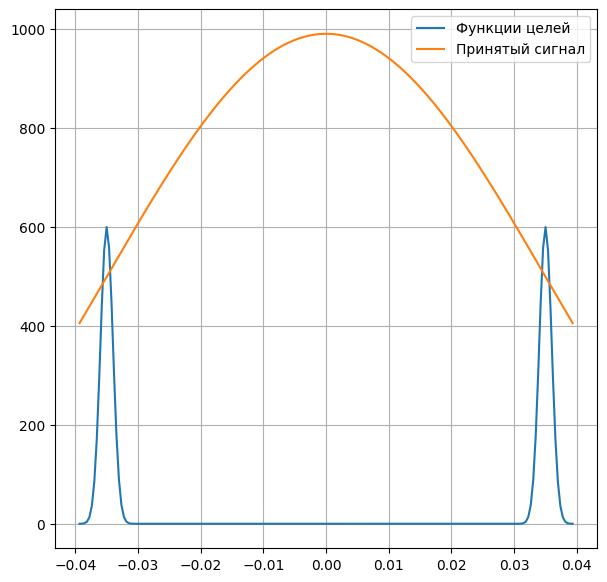

In [120]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.legend()
plt.grid()
plt.show()

In [121]:
NP = 200
NPa = np.arange(0, NP + 1)

In [122]:
Cn = int_func(func=integrand_Cn, lower = -1, upper=1, N = 20000, n = NPa)

In [123]:
C = Cn[:K+1]
CR = Cn[K+1:]

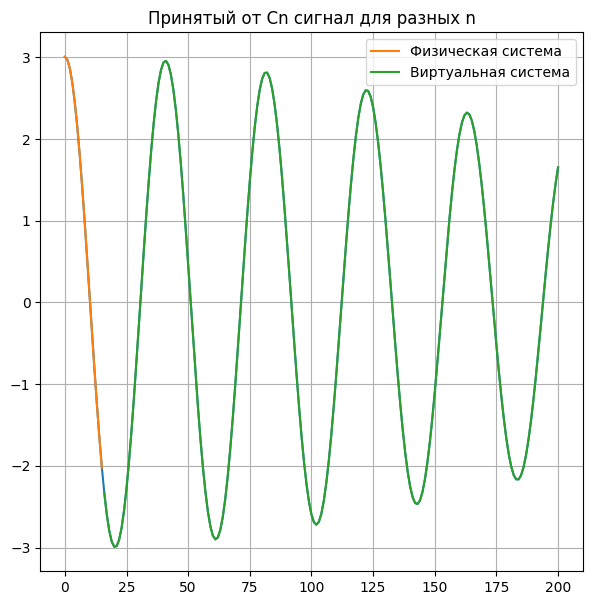

In [124]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.legend()
plt.grid()

## Модель затухающих колебаний

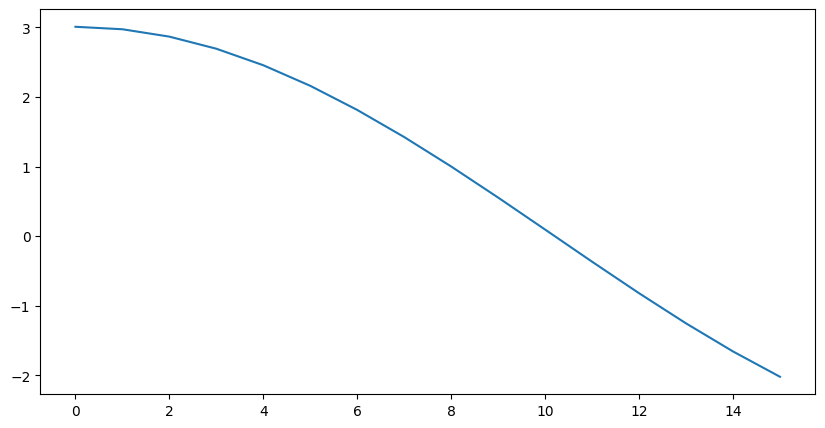

In [125]:
signal = lambda x, A, alpha, beta, epsilon: A * np.exp(alpha * x) * np.sin(beta * x + epsilon)
data = np.vstack([NPa[:K+1], C])

plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.show()

In [126]:
def grad_signal(x, data, A, alpha, beta, epsilon, clip = 255):
    grad = np.zeros(4)
    errors = signal(x, A, alpha, beta, epsilon) - data
    grad[0] = np.sum(errors * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[1] = np.sum(errors * A * x * np.exp(alpha * x) * np.sin(beta * x + epsilon))
    grad[2] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon) * x)
    grad[3] = np.sum(errors * A * np.exp(alpha * x) * np.cos(beta * x + epsilon))
    return np.clip(grad / len(x), -clip, clip)

In [127]:
params_0 = np.array([data[1, 0], 0, 0 , 1.57])
params = np.zeros(4)
n_steps = 20000
speed = 0.001

num_of_data = data.shape[1]
batch_size = num_of_data // 1

for step in np.arange(n_steps):
    for start_index in range(0, num_of_data, batch_size):
        x_batch = data[0, start_index:start_index + batch_size]
        y_batch = data[1, start_index:start_index + batch_size]
        params = params_0 - speed * grad_signal(x_batch, y_batch, 
                                                params_0[0],
                                                params_0[1],
                                                params_0[2],
                                                params_0[3])
    params_0 = params

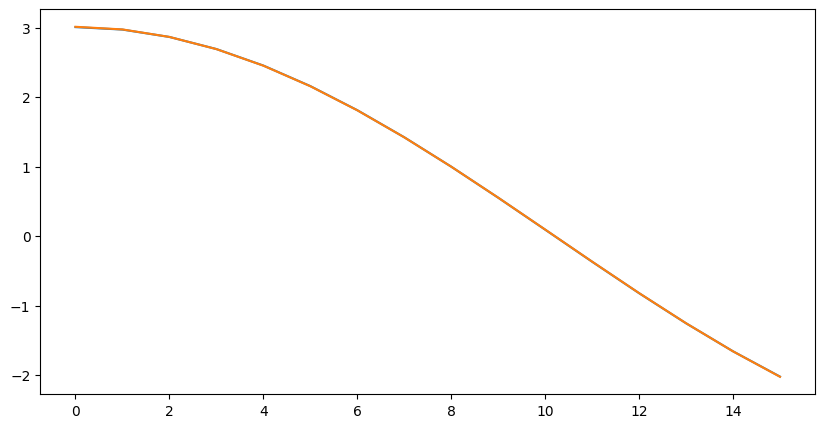

array([ 3.01290146e+00,  1.16582252e-04, -1.53207457e-01,  1.56376680e+00])

In [128]:
plt.figure(figsize = (10, 5))
plt.plot(data[0], data[1])
plt.plot(data[0], signal(data[0], params[0], params[1], params[2], params[3]))
plt.show()
params

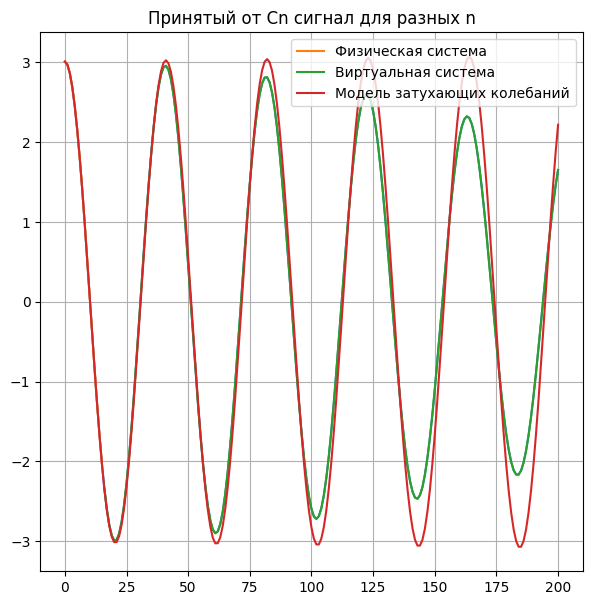

In [129]:
Cn_model = signal(NPa, params[0], params[1], params[2], params[3])

plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, Cn_model,
        label = "Модель затухающих колебаний")
plt.legend()
plt.grid()

In [130]:
print(f"Относительная ошибка по квадратам: {rel_squared_error(Cn, Cn_model)}")
print(f"Относительная ошибка по модулям: {rel_abs_error(Cn, Cn_model)}")
print(f"Средний модуль ошибки: {MAE(Cn, Cn_model)}")
print(f"Средний квадрат ошибки: {MSE(Cn, Cn_model)}")

Относительная ошибка по квадратам: 0.03885650559079246
Относительная ошибка по модулям: 0.15829202376848275
Средний модуль ошибки: 0.2667044100711764
Средний квадрат ошибки: 0.13848703822872974


## Моделирование приемной системы

In [131]:
Result = CnU(a, Cn_model)

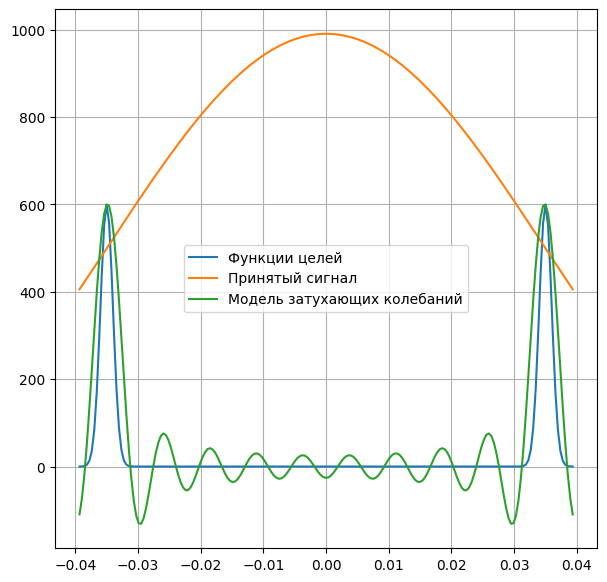

In [132]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result), label = "Модель затухающих колебаний")
plt.legend()
plt.grid()
plt.show()

## Полносвязная нейронная сеть

In [133]:
from sklearn.neural_network import MLPRegressor

In [134]:
regr = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(10), random_state=1, activation = "tanh")

In [135]:
regr.fit(data[0].reshape(-1, 1), data[1])

MLPRegressor(activation='tanh', alpha=1e-05, hidden_layer_sizes=10,
             random_state=1, solver='lbfgs')

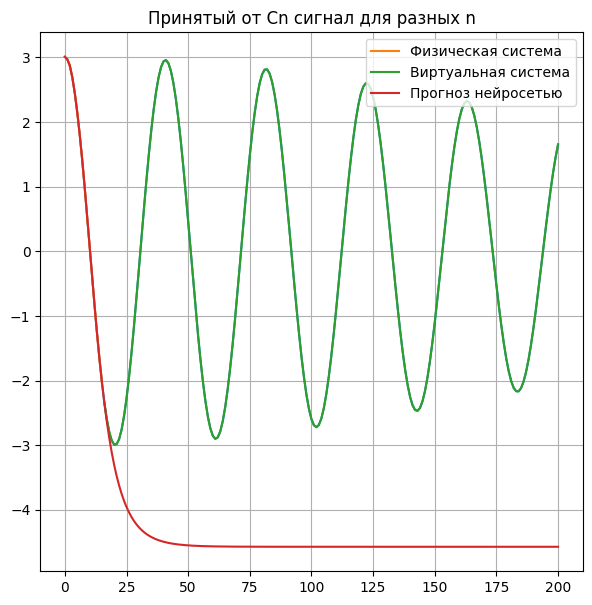

In [136]:
plt.figure(**fig_params)
plt.title("Принятый от Cn сигнал для разных n")
plt.plot(NPa, Cn)
plt.plot(NPa[:K+1], C, label = "Физическая система")
plt.plot(NPa[K+1:], CR, label = "Виртуальная система")
plt.plot(NPa, regr.predict(NPa.reshape(-1, 1)), label = "Прогноз нейросетью")
plt.legend()
plt.grid()

In [137]:
Cn_ff = regr.predict(NPa.reshape(-1, 1))

In [138]:
Result_ff = CnU(a, Cn_ff)

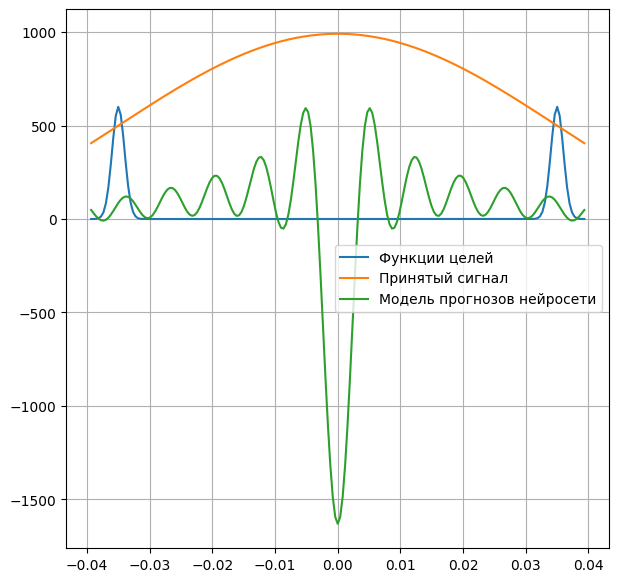

In [139]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result_ff), label = "Модель прогнозов нейросети")
plt.legend()
plt.grid()
plt.show()

## pytorch нейронная сеть siren

In [175]:
import torch
from torch import nn
from siren_pytorch import SirenNet

net = SirenNet(
    dim_in = 1,                        # input dimension, ex. 2d coor
    dim_hidden = 40,                  # hidden dimension
    dim_out = 1,                       # output dimension, ex. rgb value
    num_layers = 2,                    # number of layers
    final_activation = nn.Identity(),   # activation of final layer (nn.Identity() for direct output)
    w0_initial = 0.2 # different signals may require different omega_0 in the first layer - this is a hyperparameter
)

In [176]:
epochs = 2000
alpha = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr = alpha)
loss_func = nn.MSELoss()

data_torch_x = torch.tensor(data[0].reshape(-1, 1), dtype=torch.float)
data_torch_y = torch.tensor(data[1].reshape(-1, 1), dtype=torch.float)

In [177]:
data_torch_x

tensor([[ 0.],
        [ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.]])

In [178]:
for iter in range(0, epochs):
    optimizer.zero_grad()
    predictions = net(data_torch_x)
    loss = loss_func(predictions, data_torch_y)
    loss.backward()
    optimizer.step()

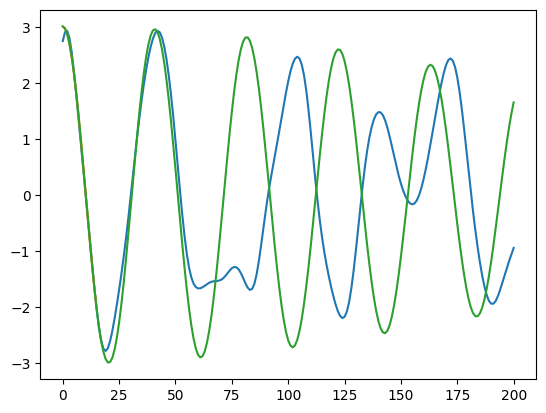

In [179]:
NPa_torch = torch.tensor(NPa.reshape(-1, 1), dtype = torch.float)

plt.plot(net(NPa_torch).detach())
plt.plot(data_torch_y)
plt.plot(Cn)

In [180]:
Cn_siren = np.array(net(NPa_torch).detach()).reshape(-1)

In [186]:
Result_siren = CnU(a, Cn_siren[:70])

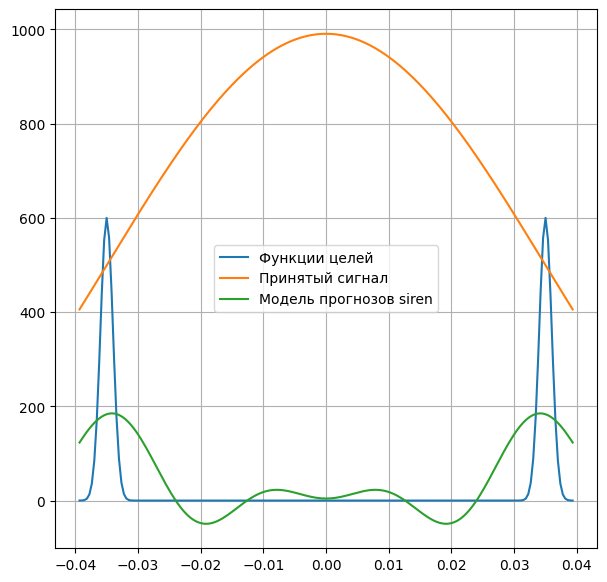

In [187]:
plt.figure(**fig_params)
plt.plot(a, Idel(a), label = "Функции целей")
plt.plot(a, vec_U00(a), label = "Принятый сигнал")
plt.plot(a, np.real(Result_siren), label = "Модель прогнозов siren")
plt.legend()
plt.grid()
plt.show()

## Авторегрессия с помощью Рекуррентных сетей

In [188]:
import torch
import torch.nn as nn

In [194]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [195]:
# Define input data
input_size = 1
sequence_length = K

# Define RNN hyperparameters
hidden_size = 20
output_size = 1

In [196]:
# Create RNN instance
rnn = RNN(input_size, hidden_size, output_size)

# Initialize hidden state
hidden = rnn.init_hidden()

In [203]:
# Pass the data through the RNN
epochs = 2000
lr = 1e-4

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr = lr)

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = 0
    for i in range(sequence_length):
        output, hidden = rnn(data_torch_x[i].reshape(1, 1, -1), hidden)
        l = loss_fn(output, data_torch_y[i])
        loss += l
    loss.backward()
    optimizer.step()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.